# Active subspaces for sensitivity analysis

A standard method to analyse dynamical systems such as models of neural dynamics is to use a sensitivity analysis. We can use the posterior obtained with `sbi`, to perform such analyses.


## Main syntax


```python
from sbi.analysis import ActiveSubspace

sensitivity = ActiveSubspace(posterior.set_default_x(x_o))
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)
projected_data = sensitivity.project(theta_project, num_dimensions=1)
```


## Example and further explanation


In [1]:
import torch
from torch.distributions import MultivariateNormal

from sbi.analysis import ActiveSubspace, pairplot
from sbi.inference import infer, simulate_for_sbi
from sbi.simulators import linear_gaussian

_ = torch.manual_seed(0)

Let's define a simple Gaussian toy example:


In [2]:
prior = MultivariateNormal(0.0 * torch.ones(2), 2 * torch.eye(2))


def simulator(theta):
    return linear_gaussian(
        theta, -0.8 * torch.ones(2), torch.tensor([[1.0, 0.98], [0.98, 1.0]])
    )


posterior = infer(simulator, prior, num_simulations=2000, method="SNPE").set_default_x(
    torch.zeros(2)
)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 86 epochs.

In [3]:
posterior_samples = posterior.sample((2000,))

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

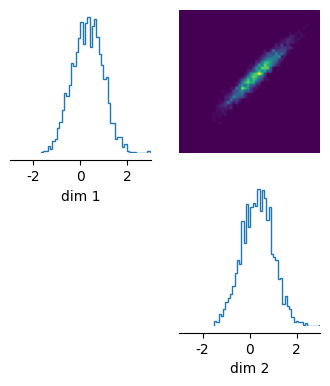

In [4]:
_ = pairplot(posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(4, 4))

When performing a sensitivity analysis on this model, we would expect that there is one direction that is less sensitive (from bottom left to top right, along the vector [1, 1]) and one direction that is more sensitive (from top left to bottom right, along [1, -1]). We can recover these directions with the `ActiveSubspace` module in `sbi`.


In [5]:
sensitivity = ActiveSubspace(posterior)
e_vals, e_vecs = sensitivity.find_directions(posterior_log_prob_as_property=True)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

The method `.find_active()` returns eigenvalues and the corresponding eigenvectors. It does so by computing the matrix:

$M = \mathbb{E}_{p(\theta|x_o)}[\nabla_{\theta}p(\theta|x_o)^T \nabla_{\theta}p(\theta|x_o)$]

It then does an eigendecomposition:
$M = Q \Lambda Q^{-1}$

A strong eigenvalue indicates that the gradient of the posterior density is large, i.e. the system output is sensitive to changes along the direction of the corresponding eigenvector (or `active`). The eigenvalue corresponding to the vector `[0.68, -0.73]` is much larger than the eigenvalue of `[0.73, 0.67]`. This matches the intuition we developed above.


In [6]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([2.5892e-06, 9.2593e-05]) 

Eigenvectors: 
 tensor([[-0.7012, -0.7130],
        [-0.7130,  0.7012]])


Lastly, we can project the data into the active dimensions. In this case, we will just use one active dimension:


In [7]:
projected_data = sensitivity.project(posterior_samples, num_dimensions=1)

## Some technical details

- The gradients and thus the eigenvectors are computed in z-scored space. The mean and standard deviation are computed w.r.t. the prior distribution. Thus, the gradients (and thus the eigenvales) reflect changes on the scale of the prior.
- The expected value used to compute the matrix $M$ is estimated using `1000` posterior samples. This value can be set with the `.find_active(num_monte_carlo_samples=...)` variable.
- How does this relate to Principal Component Analysis (PCA)? In the example above, the results of PCA would be very similar. However, there are two main differences to PCA: First, PCA ignores local changes in the posterior, whereas the active subspace can change a lot (since it computes the gradient, which is a local quantity). Second, active subspaces can be used characterize the sensitivity of any other quantity w.r.t. circuit parameters. This is outlined below:


## Computing the sensitivity of a specific summary statistic

Above, we have shown how to identify directions along which the posterior probability changes rapidly. Notably, the posterior probability reflects how consistent a specific parameter set is with **all** summary statistics, i.e. the entire $x_o$. Sometimes, we might be interested in investigating how a specific features is influenced by the parameters. This feature could be one of the values of $x_o$, but it could also be a different property.

As a neuroscience example, in Deistler et al. 2021, we obtained the posterior distribution given burst durations and delays between bursts. After having obtained the posterior, we then wanted to analyse the sensitivity of metabolic cost w.r.t. circuit parameters. The framework we presented above can easily be extended to study such questions.


In [8]:
prior = MultivariateNormal(0.0 * torch.ones(2), 2 * torch.eye(2))


def simulator(theta):
    return linear_gaussian(theta, -0.8 * torch.ones(2), torch.eye(2))


posterior = infer(simulator, prior, num_simulations=2000, method="SNPE").set_default_x(
    torch.zeros(2)
)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 74 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

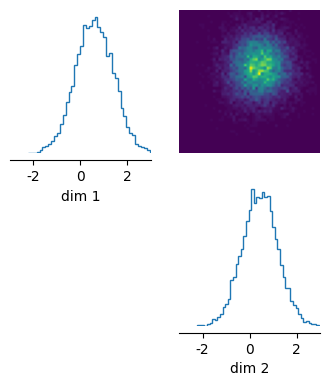

In [9]:
_ = pairplot(posterior.sample((10_000,)), limits=[[-3, 3], [-3, 3]], figsize=(4, 4))

In [10]:
sensitivity = ActiveSubspace(posterior)

This time, we begin by drawing samples from the posterior and then computing the desired property for each of the samples (i.e. you will probably have to run simulations for each theta and extract the property from the simulation output). As an example, we assume that the property is just the cube of the first dimension of the simulation output:


In [11]:
theta, x = simulate_for_sbi(simulator, posterior, 5000)
property_ = x[:, :1] ** 3  # E.g. metabolic cost.

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

To investigate the sensitivity of a given parameter, we train a neural network to predict the `property_` from the parameters and then analyse the neural network as above:

$M = \mathbb{E}_{p(\theta|x_o)}[\nabla_{\theta}f(\theta)^T \nabla_{\theta}f(\theta)$]

where $f(\cdot)$ is the trained neural network.


In [12]:
_ = sensitivity.add_property(theta, property_).train()
e_vals, e_vecs = sensitivity.find_directions()

 Training neural network. Epochs trained:  67

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
print("Eigenvalues: \n", e_vals, "\n")
print("Eigenvectors: \n", e_vecs)

Eigenvalues: 
 tensor([4.6135e-07, 3.3536e-05]) 

Eigenvectors: 
 tensor([[ 0.0457,  0.9990],
        [ 0.9990, -0.0457]])


As we can see, one of the eigenvalues is much smaller than the other one. The larger eigenvalue represents (approximately) the vector `[1.0, 0.0]`. This makes sense, because only the `property_` is influenced only by the first output which, in turn, is influenced only by the first parameter.
